Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
22.07.25 - Orchisama Das, Gloria Dal Santo
  
### L02: Artificial Reverberation 

In this assignment we will 
- Load a response measured in a shoebox room with known dimensions, source-receiver positions
- Deconvolve the sine sweep from the recorded response to extract the RIR 
- Plot the EDC, NED, and compute the broadband T60
- Synthesize the RIR with the ISM in pyroomacoustics

In [1]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import pyroomacoustics as pra

from pathlib import Path

from utils import (
    audioread,
    find_onset)
from room_acoustics.analysis import (
    compute_edc, 
    estimate_rt60,
    normalized_echo_density)
from room_acoustics.plot import (
    plot_time_domain,
    plot_spectrogram)


#### 1. Load Response and Deconvolve the RIR

We'll be using `11_Speaker_IGL_ch1.wav` and `DrySweep.wav`.  
- 1.1 Load the signals and their sampling frequency using the `audioread` function. 
- 1.2 Plot their time domain response, their spectrogram, and play them. Use `plot_time_domain` and `plot_spectrogram` from 
- 1.3 Deconvolve the signal to extract the RIR and plot it. Use the numpy's `convolve` function (The recording is fairly long! Expect it to run for a minute or so). Be careful of which `mode` to use.  

Note: the sine sweep has training and leading silence. The important information is contained between the 1st and 11th second.
You can also try to code the sine sweep yourself using the formula given in the assignment sheet. 

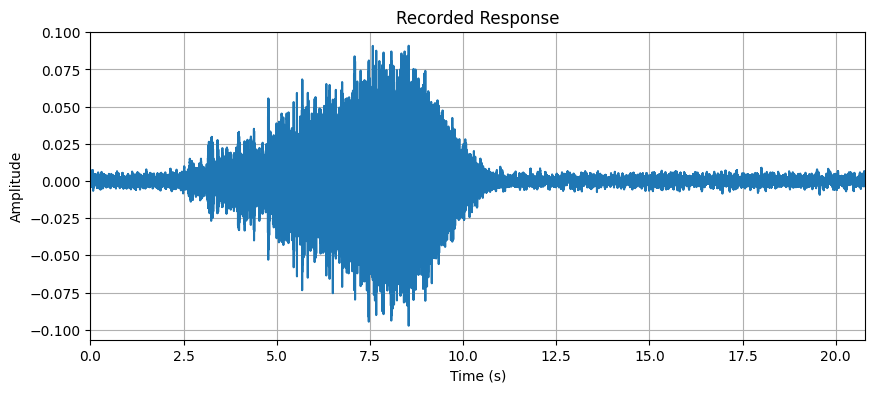

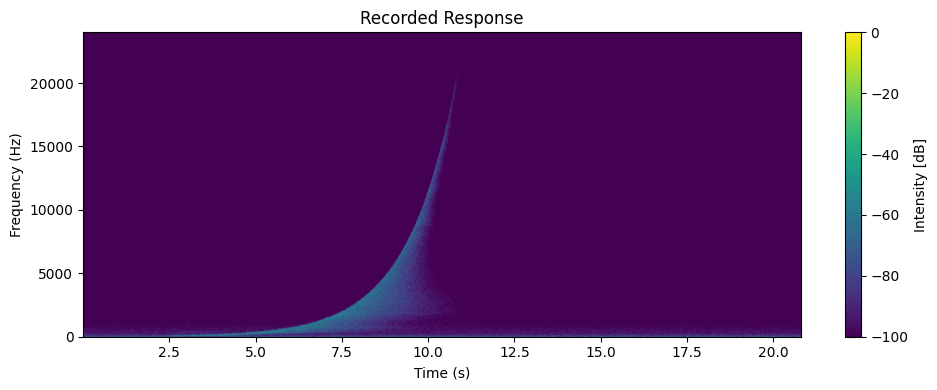

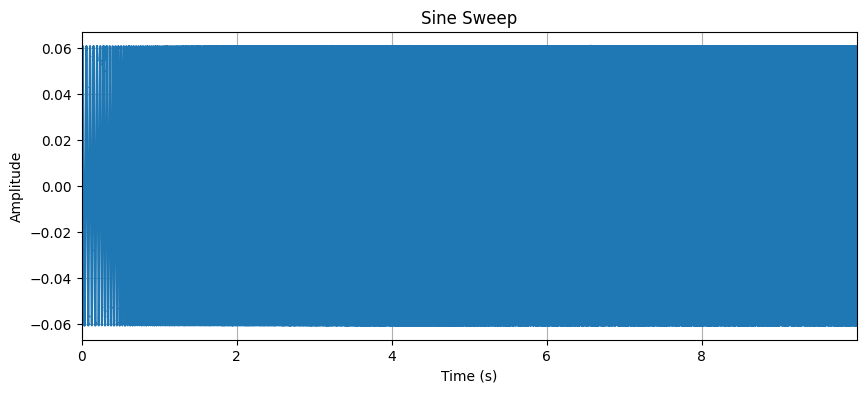

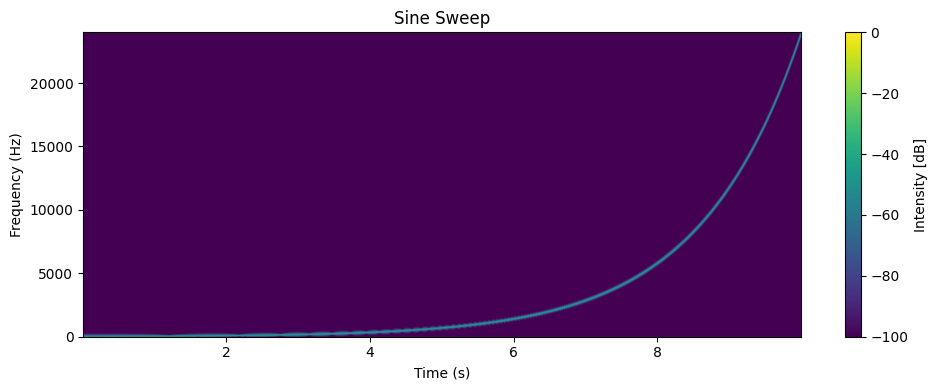

/var/folders/pk/np_tqgcj3cb6j0r1hxnnf3_c0000gn/T/ipykernel_57259/2704891056.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  onset=int(onset)


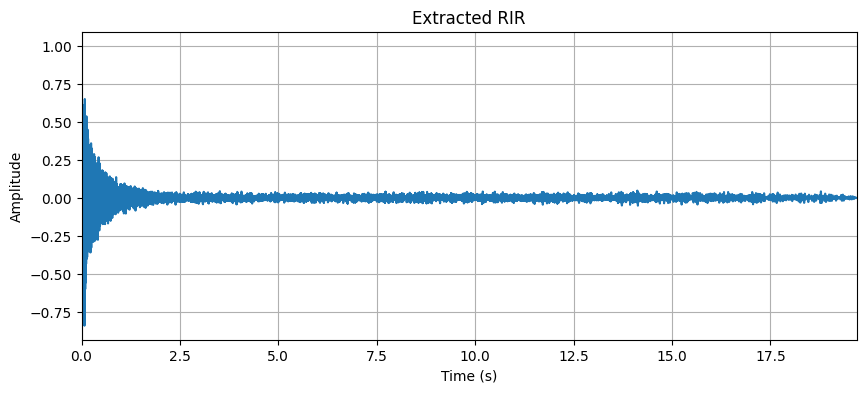

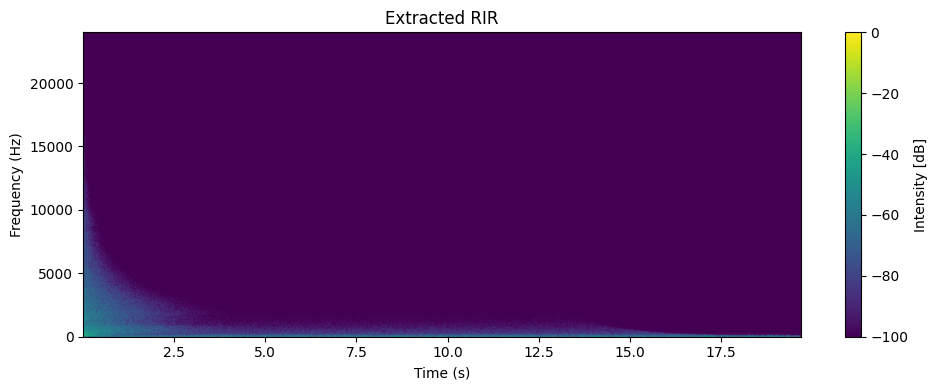

In [2]:
import scipy
# --- Load and Play Recording ---
rec_path = Path('..') / 'data' / '11_Speaker_IGL_ch1.wav'
rec, fs = audioread(str(rec_path))
plot_time_domain(rec, fs, 'Recorded Response')
plot_spectrogram(rec, fs, 'Recorded Response')
ipd.display(ipd.Audio(rec, rate=fs))


# --- Load and Play Sine Sweep ---
sweep_path = Path('..') / 'data' / 'DrySweep.wav'
sweep, fs = audioread(str(sweep_path))
# trim the sweep so that it contains only the non zero part
sweep = sweep[48000:48000 + 10*fs]
plot_time_domain(sweep, fs, 'Sine Sweep')
plot_spectrogram(sweep, fs, 'Sine Sweep')
ipd.display(ipd.Audio(sweep, rate=fs))


# --- Deconvolve the Recording with the Sine Sweep to Extract RIR ---

#### WRITE YOUR CODE ####
# Create an inverse sweep by flipping the sweep signal
inverse_sweep = sweep[::-1]
# Deconvolve the recording with the inverse sweep to extract the RIR
rir = scipy.signal.fftconvolve(rec, inverse_sweep, mode='full')
# Normalize the RIR to have maximum absolute value of 1
rir = rir / np.max(np.abs(rir))
# Find and remove the silence before the onset of the RIR (you can use the `find_onset` function)
onset = find_onset(rir)
onset=int(onset)
rir = rir[onset:]
# plot time response and spectrogram 
plot_time_domain(rir, fs, 'Extracted RIR')
plot_spectrogram(rir, fs, 'Extracted RIR')

ipd.display(ipd.Audio(rir, rate=fs))


#### 2. Extract the Acoustic Parameters

For the obtained RIR
- 2.1 Compute and plot the EDC, T60, and NED using the functions implemented during Assignment 1

Note: compute the NED only for the first 4 seconds as it gets very noisy after that

0.015
i am backwards!!
test
i am here!!


/Users/cucu/Documents/GitHub/VAIAWorkshop25Public/src/room_acoustics/analysis.py:110: RuntimeWarning: invalid value encountered in log10
  out = 10 * np.log10(out)


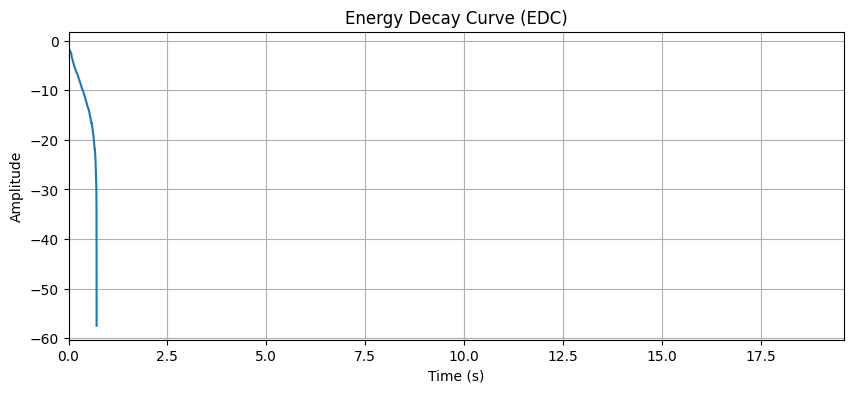

Estimated Noise Level: 0.003 (RMS)
RT60 Slope: -48.643 dB/s
RT60 Intercept: 11.267 dB
Estimated RT60: 1.233 seconds


In [5]:
# --- Compute the EDC, estimate the T60 and compute the NED (Ref: Lecture 1) ---
from importlib import reload
import room_acoustics

reload(room_acoustics.analysis)
from room_acoustics.analysis import compute_edc

#### WRITE YOUR CODE ####

# estimate noise floor from last 0.5 seconds
noise_level = np.sqrt(np.mean(rir[-int(0.05 * fs):] ** 2))

# compute EDC with noise subtraction
edc_db = compute_edc(
    rir,
    fs=fs,
    subtract_noise=True,
    noise_level=0.015,
    energy_norm=True
)
plot_time_domain(edc_db-1, fs, 'Energy Decay Curve (EDC)')
# time axis that matches EDC length
time = np.arange(len(edc_db)) / fs

# estimate T60 using realistic decay window
rt60, slope, intercept, valid_range = estimate_rt60(
    edc_db,
    time,
    decay_start_db=-10,
    decay_end_db=-30
)

# print results
print(f"Estimated Noise Level: {noise_level:.3f} (RMS)")
print(f"RT60 Slope: {slope:.3f} dB/s")
print(f"RT60 Intercept: {intercept:.3f} dB")
print(f"Estimated RT60: {rt60:.3f} seconds")

# compute ned on first 4 seconds
ned_input = rir[:int(4 * fs)]
ned = normalized_echo_density(ned_input, fs=fs)

#### 3. ISM synthesis of the RIR 

Use `pyroomacoustics` to synthesize the RIR given the room dimensions, the absorption and scattering properties of the surfaces, and source-receiver positions.
- 3.1 Instantiate the Shoebox class from pyroomacoustics. References: https://github.com/LCAV/pyroomacoustics/blob/f4144d216fd8776a91f40b600ee1a30bbcd228da/pyroomacoustics/room.py#L2987 and https://github.com/LCAV/pyroomacoustics/blob/master/examples/room_shoebox_3d_rt.py (the latter shows you an example on how to use it)
- 3.2 Run the usual acoustic parameters analysis and compare them to those of the original RIR 
- 3.3 Try different configurations (different orders of image sources, with and without ray tracing)



In [ ]:
# --- ISM synthesis of the RIR ---
room_dims = [6.1, 12.2, 6.1]  # Dimensions of the racquetball court (m)
source_pos = [5.3, 6.7, 1.52]  # Position of the source (m)
mic_pos = [1, 10.5, 1.52]  # Position of the microphone (m)

floor_abs = {
    'description': 'Wooden Floor',
    'coeffs': [0.150, 0.150, 0.110, 0.100, 0.070, 0.060, 0.070, 0.070],
    'center_freqs': [63, 125, 250, 500, 1000, 2000, 4000, 8000],
}
wall_abs = {
    'description': 'Wooden Walls',
    'coeffs': [0.042, 0.037, 0.039, 0.012, 0.004, 0.003, 0.014, 0.04],
    'center_freqs': [63, 125, 250, 500, 1000, 2000, 4000, 8000],
}
scattering = {
    "description": "Random diffuser", 
    "coeffs": [0.01, 0.01, 0.08, 0.08, 0.05, 0.08, 0.1, 0.1],
    "center_freqs": [63, 125, 250, 500, 1000, 2000, 4000, 8000],
}

materials = pra.make_materials(
    ceiling=(wall_abs, scattering),
    floor=(floor_abs, scattering),
    east=(wall_abs, scattering),
    west=(wall_abs, scattering),
    north=(wall_abs, scattering),
    south=(wall_abs, scattering),
)

shoebox = (
#### WRITE YOUR CODE ####
# use the `pra.ShoeBox` to create a room with the given dimensions, materials, and parameters
# You can try with max_order = 20 amd with/without ray tracing
)

# run the synthesis
#shoebox.image_source_model()
shoebox.ray_tracing()
shoebox.compute_rir()
rir_ism = shoebox.rir[0][0].copy()
plot_time_domain(rir_ism, fs, title=f'RIR from ISM')
plot_spectrogram(rir_ism, fs, title='RIR from ISM', clim=[-200, None])
rt60_sabine = shoebox.rt60_theory(formula="sabine")
ipd.display(ipd.Audio(rir_ism, rate=fs))

AttributeError: 'tuple' object has no attribute 'image_source_model'

#### 4. Convolve

Convolve the extracted and generated RIRs with the dry signals `data/Drums.wav`, `data/Sax.wav`, and `data/Speech.wav`.

In [ ]:
# --- Convolve Anechoic Sounds with RIRs ---
anechoic = ['Drums', 'Sax', 'Speech']

for filename in anechoic:
    rec_path = Path('..') / 'data' / f'{filename}.wav'
    rec, fs = audioread(str(rec_path))
    
    # Convolve the recording with the RIR
    #### WRITE YOUR CODE ####
    # it's good practice to normalize the convolved signal
    print(f"Convolved {filename} with RIR from recorded RIR")
    ipd.display(ipd.Audio(convolved, rate=fs))

for filename in anechoic:
    rec_path = Path('..') / 'data' / f'{filename}.wav'
    rec, fs = audioread(str(rec_path))
    
    # Convolve the recording with the RIR
    #### WRITE YOUR CODE ####
    # it's good practice to normalize the convolved signal
    print(f"Convolved {filename} with RIR from ISM")
    ipd.display(ipd.Audio(convolved, rate=fs))
